In [ ]:
!pip install evaluate > /dev/null

In [ ]:
!python -m spacy download de_core_news_sm > /dev/null

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from datasets import load_dataset
import spacy
import tqdm
import evaluate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter, OrderedDict
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4


In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
print(f"Random seeds set to {seed} for reproducible experiments")

Random seeds set to 42 for reproducible experiments


## Data Preparation and Preprocessing

In [ ]:
dataset = load_dataset("bentrevett/multi30k")

print(f"Dataset loaded successfully!")
print(f"Dataset splits: {dataset.keys()}")
print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")
print(f"\nSample data point:")
print(f"German: {dataset['train'][0]['de']}")
print(f"English: {dataset['train'][0]['en']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.jsonl: 0.00B [00:00, ?B/s]

val.jsonl: 0.00B [00:00, ?B/s]

test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset loaded successfully!
Dataset splits: dict_keys(['train', 'validation', 'test'])
Training samples: 29000
Validation samples: 1014
Test samples: 1000

Sample data point:
German: Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
English: Two young, White males are outside near many bushes.


In [ ]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

print(f"Dataset partitioning complete:")
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(valid_data)} samples")
print(f"Test set: {len(test_data)} samples")

Dataset partitioning complete:
Training set: 29000 samples
Validation set: 1014 samples
Test set: 1000 samples


In [ ]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

print(f"Language models loaded successfully:")
print(f"English model: {en_nlp.meta['name']} (v{en_nlp.meta['version']})")
print(f"German model: {de_nlp.meta['name']} (v{de_nlp.meta['version']})")

sample_en = "A man is riding a bicycle."
sample_de = "Ein Mann fährt Fahrrad."
print(f"\nTokenization examples:")
print(f"English: '{sample_en}' -> {[token.text for token in en_nlp.tokenizer(sample_en)]}")
print(f"German: '{sample_de}' -> {[token.text for token in de_nlp.tokenizer(sample_de)]}")

Language models loaded successfully:
English model: core_web_sm (v3.8.0)
German model: core_news_sm (v3.8.0)

Tokenization examples:
English: 'A man is riding a bicycle.' -> ['A', 'man', 'is', 'riding', 'a', 'bicycle', '.']
German: 'Ein Mann fährt Fahrrad.' -> ['Ein', 'Mann', 'fährt', 'Fahrrad', '.']


In [ ]:
class Vocab:
    def __init__(self, tokens, min_freq=1, specials=None):
        self.specials = specials if specials else []
        self.min_freq = min_freq

        counter = Counter()
        for token_list in tokens:
            counter.update(token_list)

        self.itos = self.specials.copy()
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = {token: idx for idx, token in enumerate(self.itos)}
        self.default_index = None

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.default_index if self.default_index is not None else 0)

    def set_default_index(self, index):
        self.default_index = index

    def lookup_indices(self, tokens):
        return [self[token] for token in tokens]

    def lookup_tokens(self, indices):
        return [self.itos[idx] for idx in indices]

In [ ]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]

    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]

    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]

    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [ ]:
max_length = 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

print(f"Tokenization complete!")
print(f"Sample tokenized data:")
print(f"German tokens: {train_data[0]['de_tokens'][:10]}...")
print(f"English tokens: {train_data[0]['en_tokens'][:10]}...")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenization complete!
Sample tokenized data:
German tokens: ['<sos>', 'zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der']...
English tokens: ['<sos>', 'two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many']...


In [ ]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = Vocab(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = Vocab(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

print(f"Vocabulary Statistics:")
print(f"English vocabulary size: {len(en_vocab):,}")
print(f"German vocabulary size: {len(de_vocab):,}")
print(f"Minimum frequency threshold: {min_freq}")
print(f"\nSpecial token indices:")
print(f"  <unk>: {en_vocab[unk_token]}")
print(f"  <pad>: {en_vocab[pad_token]}")
print(f"  <sos>: {en_vocab[sos_token]}")
print(f"  <eos>: {en_vocab[eos_token]}")

Vocabulary Statistics:
English vocabulary size: 5,893
German vocabulary size: 7,853
Minimum frequency threshold: 2

Special token indices:
  <unk>: 0
  <pad>: 1
  <sos>: 2
  <eos>: 3


In [ ]:
assert en_vocab[unk_token] == de_vocab[unk_token], "UNK token indices must match"
assert en_vocab[pad_token] == de_vocab[pad_token], "PAD token indices must match"

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

print(f"Special token verification passed!")
print(f"UNK index: {unk_index}")
print(f"PAD index: {pad_index}")

Special token verification passed!
UNK index: 0
PAD index: 1


In [ ]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

print(f"Default indices set to UNK token ({unk_index})")
print(f"Unknown words will be mapped to: '{unk_token}'")

Default indices set to UNK token (0)
Unknown words will be mapped to: '<unk>'


In [ ]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [ ]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

print(f"Numericalization complete!")
print(f"Sample numericalized data:")
print(f"German indices: {train_data[0]['de_ids'][:10]}...")
print(f"English indices: {train_data[0]['en_ids'][:10]}...")

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Numericalization complete!
Sample numericalized data:
German indices: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]...
English indices: [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]...


In [ ]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

print(f"Dataset format configured for PyTorch tensors")
print(f"Formatted columns: {format_columns}")

Dataset format configured for PyTorch tensors
Formatted columns: ['en_ids', 'de_ids']


In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = [example["en_ids"] for example in batch]

        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)

        batch = {
            "de_ids": batch_de_ids,
            "en_ids": batch_en_ids,
        }
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 256

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

print(f"DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_data_loader)}")
print(f"Validation batches: {len(valid_data_loader)}")
print(f"Test batches: {len(test_data_loader)}")

DataLoaders created successfully!
Batch size: 256
Training batches: 114
Validation batches: 4
Test batches: 4


## Model Architecture Implementation

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v_fc(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

In [ ]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]
        for t in range(1, trg_length):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

In [ ]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout
)

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)

print(f"Model created and moved to device: {device}")
print(f"Input vocabulary size (German): {input_dim:,}")
print(f"Output vocabulary size (English): {output_dim:,}")

Model created and moved to device: cuda
Input vocabulary size (German): 7,853
Output vocabulary size (English): 5,893


## Model Instantiation and Configuration

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param)
        else:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

print(f"Model weights initialized using Xavier uniform distribution")

Model weights initialized using Xavier uniform distribution


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"The model has {total_params:,} trainable parameters")
print(f"Model size: ~{total_params * 4 / 1024**2:.2f} MB (assuming 32-bit floats)")

The model has 20,518,405 trainable parameters
Model size: ~78.27 MB (assuming 32-bit floats)


In [ ]:
optimizer = optim.Adam(model.parameters())

print(f"Optimizer: Adam")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Optimizer: Adam
Learning rate: 0.001


## Training Setup and Optimization

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

print(f"Loss function: CrossEntropyLoss")
print(f"Ignoring padding tokens at index: {pad_index}")

Loss function: CrossEntropyLoss
Ignoring padding tokens at index: 1


In [ ]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            output = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

  5%|▌         | 1/20 [01:34<30:02, 94.85s/it]

	Train Loss:   5.185 | Train PPL: 178.555
	Valid Loss:   4.898 | Valid PPL: 133.960


 10%|█         | 2/20 [03:07<27:58, 93.27s/it]

	Train Loss:   4.295 | Train PPL:  73.334
	Valid Loss:   4.674 | Valid PPL: 107.111


 15%|█▌        | 3/20 [04:39<26:15, 92.70s/it]

	Train Loss:   3.864 | Train PPL:  47.668
	Valid Loss:   4.428 | Valid PPL:  83.806


 20%|██        | 4/20 [06:12<24:49, 93.09s/it]

	Train Loss:   3.357 | Train PPL:  28.703
	Valid Loss:   3.967 | Valid PPL:  52.843


 25%|██▌       | 5/20 [07:45<23:15, 93.03s/it]

	Train Loss:   2.920 | Train PPL:  18.550
	Valid Loss:   3.621 | Valid PPL:  37.368


 30%|███       | 6/20 [09:18<21:39, 92.81s/it]

	Train Loss:   2.560 | Train PPL:  12.934
	Valid Loss:   3.531 | Valid PPL:  34.145


 35%|███▌      | 7/20 [10:50<20:06, 92.82s/it]

	Train Loss:   2.264 | Train PPL:   9.623
	Valid Loss:   3.426 | Valid PPL:  30.759


 40%|████      | 8/20 [12:23<18:32, 92.68s/it]

	Train Loss:   2.045 | Train PPL:   7.732
	Valid Loss:   3.443 | Valid PPL:  31.265


 45%|████▌     | 9/20 [13:56<16:59, 92.72s/it]

	Train Loss:   1.880 | Train PPL:   6.556
	Valid Loss:   3.479 | Valid PPL:  32.437


 50%|█████     | 10/20 [15:28<15:27, 92.77s/it]

	Train Loss:   1.689 | Train PPL:   5.415
	Valid Loss:   3.522 | Valid PPL:  33.861


 55%|█████▌    | 11/20 [17:01<13:55, 92.79s/it]

	Train Loss:   1.574 | Train PPL:   4.825
	Valid Loss:   3.513 | Valid PPL:  33.559


 60%|██████    | 12/20 [18:34<12:21, 92.71s/it]

	Train Loss:   1.347 | Train PPL:   3.846
	Valid Loss:   3.485 | Valid PPL:  32.606


 65%|██████▌   | 13/20 [20:06<10:47, 92.57s/it]

	Train Loss:   1.291 | Train PPL:   3.635
	Valid Loss:   3.521 | Valid PPL:  33.813


 65%|██████▌   | 13/20 [21:39<11:39, 99.95s/it]

Early stopping at epoch 14


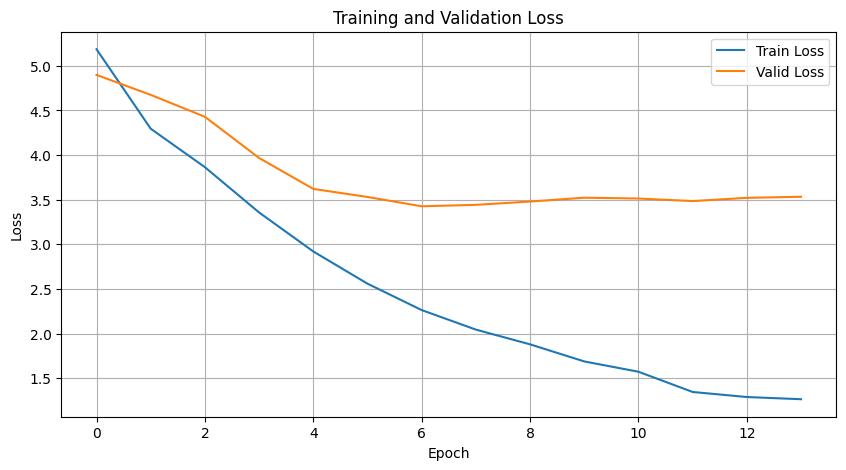

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 20
clip = 1.0
teacher_forcing_ratio = 0.6
patience = 7

best_valid_loss = float("inf")

train_losses = []
valid_losses = []

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

early_stopping_counter = 0

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    scheduler.step(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "de2en-model.pt")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.load_state_dict(torch.load("de2en-model.pt"))


test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.445 | Test PPL:  31.359 |


## Model Evaluation and Testing

In [ ]:
def translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

## Inference and Translation

In [ ]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [ ]:
sentence = train_data[0]["de"]
expected_translation = train_data[0]["en"]

sentence, expected_translation

('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.',
 'Two young, White males are outside near many bushes.')

In [ ]:
translation, sentence_tokens, attention  = translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
)

In [ ]:
translation

['<sos>',
 'two',
 'young',
 'white',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'trees',
 '.',
 '<eos>']

In [ ]:
sentence_tokens

['<sos>',
 'zwei',
 'junge',
 'weiße',
 'männer',
 'sind',
 'im',
 'freien',
 'in',
 'der',
 'nähe',
 'vieler',
 'büsche',
 '.',
 '<eos>']

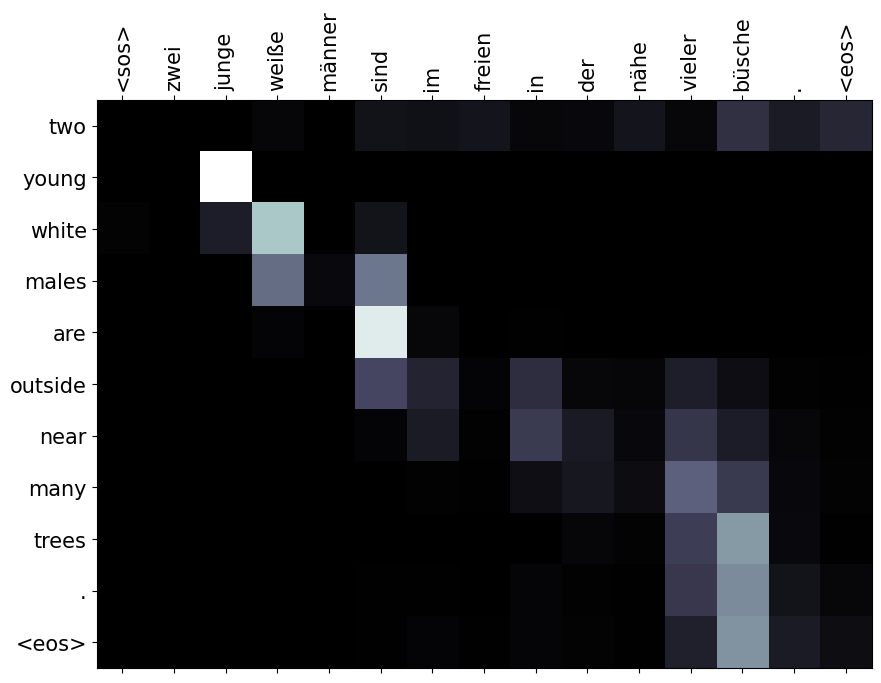

In [ ]:
plot_attention(sentence_tokens, translation, attention)

In [ ]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_vocab,
        de_vocab,
        en_nlp,
        de_nlp,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]

print(f"Generated {len(translations)} translations for test set")

100%|██████████| 1000/1000 [00:15<00:00, 65.96it/s]

Generated 1000 translations for test set


## Quantitative Evaluation with BLEU Score

In [ ]:
bleu = evaluate.load("bleu")

print(f"BLEU metric loaded successfully")

BLEU metric loaded successfully


In [ ]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

print(f"Formatted {len(predictions)} predictions")
print(f"Formatted {len(references)} references")
print(f"\nSample prediction: {predictions[0]}")
print(f"Sample reference: {references[0][0]}")

Formatted 1000 predictions
Formatted 1000 references

Sample prediction: a man in an orange hat is welding something .
Sample reference: A man in an orange hat starring at something.


In [ ]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [ ]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [ ]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

print(f"BLEU Score Results:")
print(f"Overall BLEU: {results['bleu']:.4f}")
print(f"BLEU-1: {results['precisions'][0]:.4f}")
print(f"BLEU-2: {results['precisions'][1]:.4f}")
print(f"BLEU-3: {results['precisions'][2]:.4f}")
print(f"BLEU-4: {results['precisions'][3]:.4f}")

BLEU Score Results:
Overall BLEU: 0.3203
BLEU-1: 0.6327
BLEU-2: 0.3931
BLEU-3: 0.2532
BLEU-4: 0.1672


## Loading Pre-trained Model (Optional)


In [ ]:
ximport gdown
#https://drive.google.com/file/d/1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd/view?usp=drive_link
gdown.download(id="1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd", output="de2en-model_download.pt")

Downloading...
From (original): https://drive.google.com/uc?id=1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd
From (redirected): https://drive.google.com/uc?id=1JcdqzqbyvfKhfZ1jV5by4tlOEQOk0Syd&confirm=t&uuid=3d54d2dc-16c7-4bea-86f0-5ebafe462bb6
To: /content/de2en-model_download.pt
100%|██████████| 82.1M/82.1M [00:01<00:00, 47.5MB/s]


'de2en-model_download.pt'

In [ ]:
input_dim = 7853
output_dim = 5893
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.6
decoder_dropout = 0.6
n_layers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout
)

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [ ]:
model.load_state_dict(torch.load("de2en-model_download.pt"))

<All keys matched successfully>

In [ ]:
sentence = "Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt"

Translated sentence: a man in an orange hat is welding something .


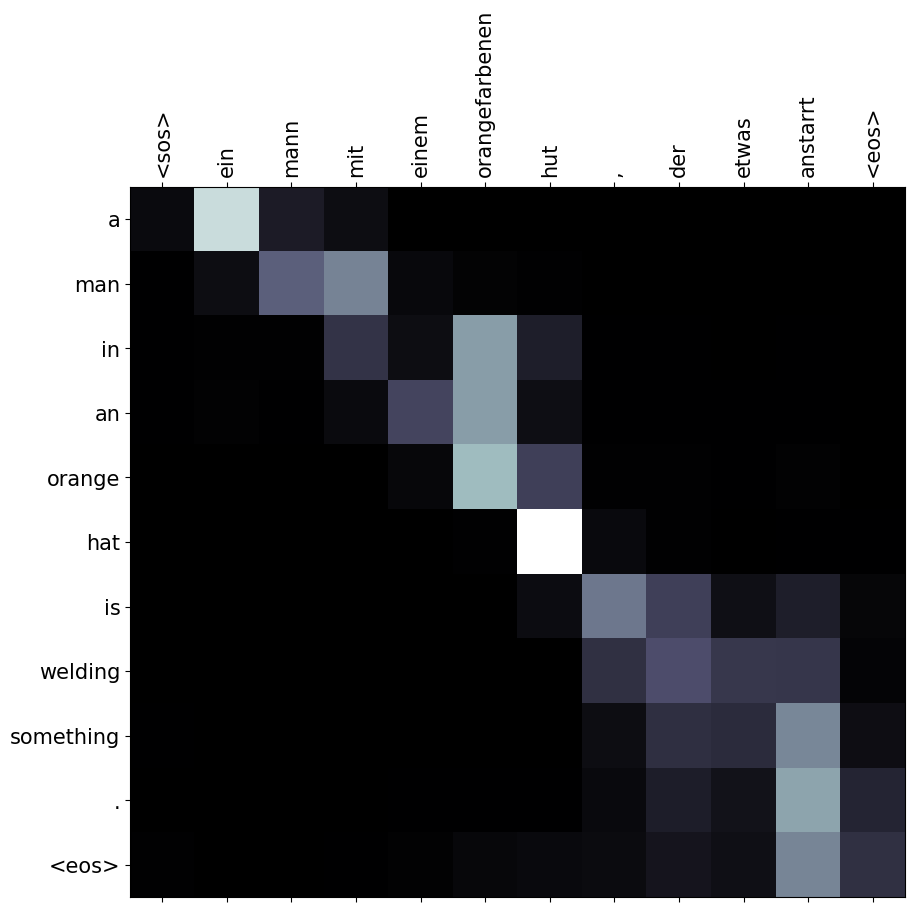

In [ ]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_vocab,
    de_vocab,
    en_nlp,
    de_nlp,
    lower,
    sos_token,
    eos_token,
    device,
)
print("Translated sentence:", " ".join(translation[1:-1]))
plot_attention(sentence_tokens, translation, attention)